# Atlas flatmap (SSCx): Voxel interpolation

In [1]:
# Initialization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from voxcell.nexus.voxelbrain import Atlas
from bluepy import Circuit
from bluepy import Cell
import os

from scipy.interpolate import griddata
from scipy.interpolate import interpn
from scipy.spatial import distance_matrix
import progressbar

In [2]:
# Paths
atlas_path = '/gpfs/bbp.cscs.ch/project/proj83/data/atlas/S1/MEAN/P14-MEAN'
flatmap_path = '/gpfs/bbp.cscs.ch/project/proj83/home/bolanos'
circuit_path = '/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805'
file_prefix = 'SSCx_'

In [3]:
# Load atlas
brain_atlas = Atlas.open(atlas_path)
region_map = brain_atlas.load_region_map()
brain_regions = brain_atlas.load_data('brain_regions')

reg_ids = list(np.unique(brain_regions.raw[brain_regions.raw > 0]))
reg_acrs = [region_map.get(rid, 'acronym') for rid in reg_ids]
reg_ids, reg_acrs = zip(*filter(lambda x: x[1].split(';')[0] not in ['S1', 'S2', 'S1BF'], zip(reg_ids, reg_acrs)))
regions, layers = zip(*[racr.split(';') for racr in reg_acrs])

# Load flatmap
flatmap_atlas = Atlas.open(flatmap_path)
flatmap = flatmap_atlas.load_data('BB_Rat_SSCX_flatmap_v2')
depths = flatmap_atlas.load_data('BB_Rat_SSCX_flatmap_v2_depths')
assert flatmap.raw.shape[:3] == depths.raw.shape, 'ERROR: Flatmap and depths map sizes inconsistent!'
assert np.all(flatmap.voxel_dimensions == depths.voxel_dimensions), 'ERROR: Flatmap and depths map voxels inconsistent!'
assert np.all(flatmap.bbox == depths.bbox), 'ERROR: Flatmap and depths map bounding boxes inconsistent!'

# Load circuit
c = Circuit(circuit_path + '/CircuitConfig')

In [49]:
target_gids = np.array([813822, 833513, 871593, 1018028, 1051007, 1152689, 1532590, 1651940, 1662025, 1806324, 1816032]) + 1
### GIDs or indices?????

reg_sel = np.unique(c.cells.get(target_gids, properties='region'))
lay_sel = np.unique(c.cells.get(target_gids, properties='layer'))
nrn_pos = c.cells.positions(c.cells.ids({'region': reg_sel, 'layer': lay_sel}))
print(f'INFO: Selected {nrn_pos.shape[0]} neurons in region(s) "{",".join(reg_sel)}" and layer(s) {",".join([str(lay) for lay in lay_sel])}')

INFO: Selected 218308 neurons in region(s) "S1J" and layer(s) 6


In [35]:
# Convert cell positions to flat space (w/o within-voxel interpolation)
pixel_scale = [34.0, 34.0] #[flatmap.voxel_dimensions[0], flatmap.voxel_dimensions[1]] # Actual scale unknown!!
flat_x = flatmap.lookup(nrn_pos.to_numpy())[:, 0]
flat_y = flatmap.lookup(nrn_pos.to_numpy())[:, 1]
flat_z = depths.lookup(nrn_pos.to_numpy())

flat_x[flat_x != -1] = flat_x[flat_x != -1] * pixel_scale[0]
flat_y[flat_y != -1] = flat_y[flat_y != -1] * pixel_scale[1]

flat_pos = pd.DataFrame(np.vstack((flat_x, flat_y, flat_z)).T, index=nrn_pos.index, columns=['flat_x', 'flat_y', 'depth'])
flat_pos.index.name = 'gid'
flat_pos[flat_pos == -1] = np.nan
sel_valid = np.all(np.isfinite(flat_pos), 1)
print(f'Converted {np.sum(sel_valid)} of {len(sel_valid)} cells to flat space ({np.sum(np.logical_not(sel_valid))} invalid)!')

unq_val, unq_cnt = np.unique(flat_pos[sel_valid], axis=0, return_counts=True)
if len(unq_val) > 0:
    print('Duplicate entries:', end=' ')
    for n in range(1, max(unq_cnt) + 1):
        print(f'{np.sum(unq_cnt == n)} x {n}', end=', ' if n < max(unq_cnt) else '\n')

Converted 123170 of 218308 cells to flat space (95138 invalid)!
Duplicate entries: 324 x 1, 904 x 2, 1605 x 3, 2325 x 4, 2672 x 5, 2759 x 6, 2432 x 7, 2104 x 8, 1521 x 9, 1015 x 10, 646 x 11, 391 x 12, 211 x 13, 142 x 14, 81 x 15, 40 x 16, 23 x 17, 11 x 18, 4 x 19, 5 x 20, 0 x 21, 3 x 22, 0 x 23, 3 x 24, 0 x 25, 0 x 26, 1 x 27


In [ ]:
# Interpolate missing values & within voxels (linear interpolation if possible, nearest-neighbor otherwise; voxel values assumed to correspond to voxel center)
map_indices = flatmap.positions_to_indices(nrn_pos.to_numpy(), keep_fraction=True) # Keep fractions within voxels => fraction x.5 corresponds to voxel center
map_pos = np.floor(map_indices) + 0.5 # Voxel values assumed to correspond to voxel center

# (1. linear interpolation)
flat_x_intpl = griddata(map_pos[flat_x != -1], flat_x[flat_x != -1], map_indices)
flat_y_intpl = griddata(map_pos[flat_y != -1], flat_y[flat_y != -1], map_indices)
flat_z_intpl = griddata(map_pos[flat_z != -1], flat_z[flat_z != -1], map_indices)

# (2. nearest-neighbor interpolation)
flat_x_intpl[np.isnan(flat_x_intpl)] = griddata(map_pos[flat_x != -1], flat_x[flat_x != -1], map_indices[np.isnan(flat_x_intpl)], method='nearest')
flat_y_intpl[np.isnan(flat_y_intpl)] = griddata(map_pos[flat_y != -1], flat_y[flat_y != -1], map_indices[np.isnan(flat_y_intpl)], method='nearest')
flat_z_intpl[np.isnan(flat_z_intpl)] = griddata(map_pos[flat_z != -1], flat_z[flat_z != -1], map_indices[np.isnan(flat_z_intpl)], method='nearest')

flat_pos_intpl = pd.DataFrame(np.vstack((flat_x_intpl, flat_y_intpl, flat_z_intpl)).T, index=nrn_pos.index, columns=['flat_x', 'flat_y', 'depth'])
flat_pos_intpl.index.name = 'gid'
assert np.all(np.isfinite(flat_pos_intpl)), 'ERROR: Interpolation error!'

unq_val, unq_cnt = np.unique(flat_pos_intpl, axis=0, return_counts=True)
if len(unq_val) > 0:
    print('Duplicate entries after interpolation:', end=' ')
    for n in range(1, max(unq_cnt) + 1):
        print(f'{np.sum(unq_cnt == n)} x {n}', end=', ' if n < max(unq_cnt) else '\n')

In [38]:
# Compare with nrn_info table
data_path = '/gpfs/bbp.cscs.ch/project/proj102/scratch/SSCX_BioM/matrices'
nrn_fn = 'neuron_info.feather'
nrn_table = pd.read_feather(os.path.join(data_path, nrn_fn))

In [101]:
nrn_table.loc[np.isin(nrn_table['gid'], target_gids)]

,layer,mtype,x,y,z,gid,ss_flat_x,depth,ss_flat_y
813822,6,L6_BPC,2830.289468,-2983.857441,-3061.748465,813823,NaN,NaN,NaN
833513,6,L6_BPC,3416.298069,-3099.646181,-4545.126545,833514,NaN,NaN,NaN
871593,6,L6_BPC,3087.645473,-3007.292115,-2987.506350,871594,NaN,NaN,NaN
1018028,6,L6_UPC,2917.919946,-2991.321928,-3026.134810,1018029,NaN,NaN,NaN
1051007,6,L6_UPC,2845.110680,-2988.172200,-3083.690862,1051008,NaN,NaN,NaN
1152689,6,L6_HPC,2726.173373,-3039.583795,-3084.994500,1152690,NaN,NaN,NaN
1532590,6,L6_IPC,2795.990731,-2929.656268,-3007.451697,1532591,NaN,NaN,NaN
1651940,6,L6_IPC,3197.734473,-2975.091571,-4510.625489,1651941,NaN,NaN,NaN
1662025,6,L6_IPC,2918.557641,-3047.288182,-3030.870380,1662026,NaN,NaN,NaN
1806324,6,L6_TPC:A,3383.977189,-2973.731184,-4546.854596,1806325,NaN,NaN,NaN


In [119]:
flat_tab_target = flat_pos_intpl.loc[target_gids]
flat_tab_target

,flat_x,flat_y,depth
gid,,,
813823,272.000000,680.0,1728.000000
833514,1768.000000,34.0,1262.000000
871594,238.000000,612.0,1448.000000
1018029,238.000000,578.0,1575.000000
1051008,272.000000,680.0,1728.000000
1152690,272.000000,646.0,1796.000000
1532591,272.000000,680.0,1707.000000
1651941,1802.000000,34.0,1558.000000
1662026,238.000000,578.0,1575.000000


In [123]:
flat_tab_target.to_hdf('flat_table.h5', 'flat_table')
flat_tab_target.to_csv('flat_table.csv')

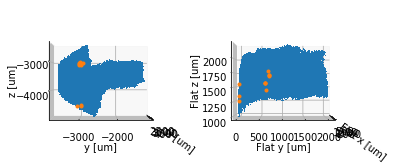

In [66]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
plt.plot(nrn_pos['x'], nrn_pos['y'], nrn_pos['z'], ',')
plt.plot(nrn_pos.loc[target_gids, 'x'], nrn_pos.loc[target_gids, 'y'], nrn_pos.loc[target_gids, 'z'], '.')
ax.view_init(0, 0)
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
ax.set_zlabel('z [um]')

ax = fig.add_subplot(1, 2, 2, projection='3d')
plt.plot(flat_pos_intpl['x'], flat_pos_intpl['y'], flat_pos_intpl['z'], ',')
plt.plot(flat_pos_intpl.loc[target_gids, 'x'], flat_pos_intpl.loc[target_gids, 'y'], flat_pos_intpl.loc[target_gids, 'z'], '.')
ax.view_init(0, 0)
ax.set_xlabel('Flat x [um]')
ax.set_ylabel('Flat y [um]')
ax.set_zlabel('Flat z [um]')

plt.show()

In [99]:
# Compare cell distances in atlas space vs. flat space
np.random.seed(0)
num_sel = 0
gids_sel = nrn_pos.index[np.random.permutation([True] * num_sel + [False] * (nrn_pos.shape[0] - num_sel))]
gids_sel = np.unique(np.hstack([gids_sel, target_gids]))
nrn_pos_sel = nrn_pos.loc[gids_sel]
flat_pos_intpl_sel = flat_pos_intpl.loc[gids_sel]

dist_mat = distance_matrix(nrn_pos_sel.to_numpy(), nrn_pos_sel.to_numpy())
dist_mat_flat_intpl = distance_matrix(flat_pos_intpl_sel.to_numpy(), flat_pos_intpl_sel.to_numpy())


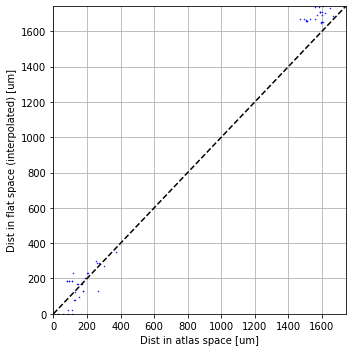

In [100]:
# Scatter plots
triu_idx = np.triu_indices_from(dist_mat, 1)

dist_val = dist_mat[triu_idx]
dist_val_flat_intpl = dist_mat_flat_intpl[triu_idx]

dist_max = max(max(dist_val), max(dist_val_flat_intpl))

plt.figure(figsize=(5, 5))
plt.plot(dist_val, dist_val_flat_intpl, 'b.', alpha=1.0, markersize=1.0)
plt.plot([0, dist_max], [0, dist_max], 'k--')
plt.xlim((0, dist_max))
plt.ylim((0, dist_max))
plt.grid(True)
plt.xlabel('Dist in atlas space [um]')
plt.ylabel('Dist in flat space (interpolated) [um]')

plt.tight_layout()
plt.savefig(file_prefix + 'dist_scatter_plots.png', dpi=300)
plt.show()

In [ ]:
#########################

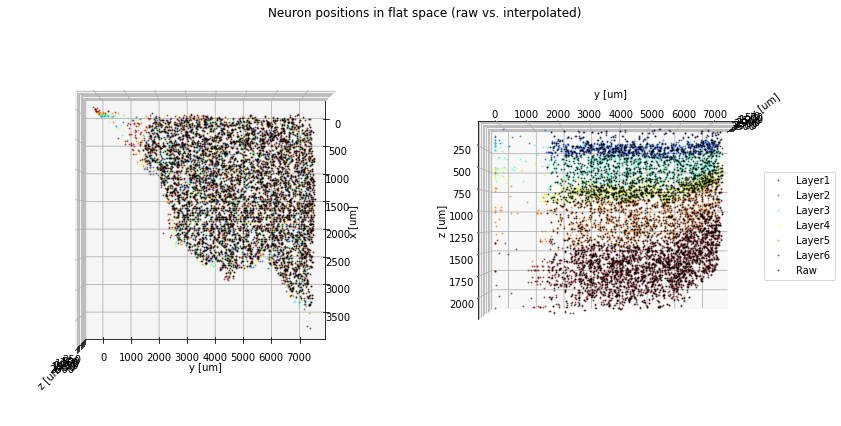

In [38]:
# Visualize neuron positions in flat space (raw vs. interpolated)
num_layers = len(np.unique(layers))
lcolors = plt.cm.jet(np.linspace(0, 1, num_layers))
views = [[90, 0], [180, 0]]
fig = plt.figure(figsize=(6 * len(views), 6))
plt.gcf().patch.set_facecolor('w')
for vidx, v in enumerate(views):
    ax = fig.add_subplot(1, len(views), vidx + 1, projection='3d')
    lgd_intpl = np.zeros(num_layers, dtype=bool)
    
    for ridx in range(len(reg_ids)):
        racr = reg_acrs[ridx]
        reg = racr.split(';')[0]
        lay = int(racr.split(';')[1][1:])
        lidx = lay - 1
        pos = flat_pos_intpl.loc[np.intersect1d(c.cells.ids({'region': reg, 'layer': lay}), cell_ids_sel)]
        if pos.shape[0] > 0:
            plt.plot(pos['x'], pos['y'], pos['z'], '.', color=lcolors[lidx, :], markersize=2, alpha=0.5, label=f'Layer{lidx+1}' if not lgd_intpl[lidx] else None)
            lgd_intpl[lidx] = True
    
    plt.plot(flat_pos['x'], flat_pos['y'], flat_pos['z'], '.', color='k', markersize=2, alpha=0.5, label='Raw')
    #plt.plot(flat_pos_intpl['x'][~sel_valid], flat_pos_intpl['y'][~sel_valid], flat_pos_intpl['z'][~sel_valid], 'x', color='m', markersize=2, alpha=0.5, label='Invalid') # Invalid lookup positions (w/o interpolation)
    
    ax.view_init(*v)
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')
    ax.set_zlabel('z [um]')
plt.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.suptitle('Neuron positions in flat space (raw vs. interpolated)')
plt.tight_layout()
plt.savefig(file_prefix + 'flat_space.png', dpi=300)
plt.show()

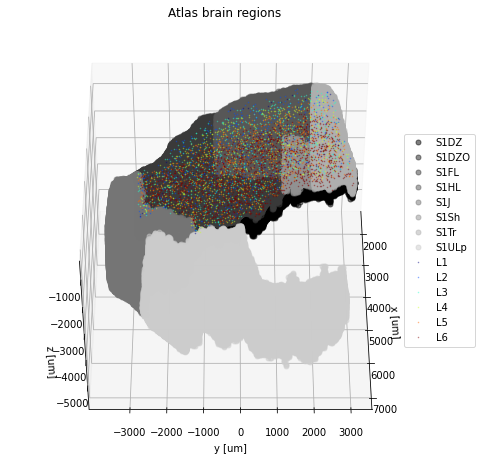

In [39]:
# Visualize atlas regions + cell positions in atlas space
reg_names = np.unique(regions)
# reg_names = ['S1FL', 'S1HL', 'S1Sh', 'S1Tr']
rcolors = plt.cm.gray(np.linspace(0.0, 0.8, len(reg_names)))
fig = plt.figure(figsize=(8, 8))
plt.gcf().patch.set_facecolor('w')
ax = fig.add_subplot(111, projection='3d')
for ridx, rname in enumerate(reg_names):
    rids = np.array(reg_ids)[[rname in r for r in reg_acrs]]
    x, y, z = zip(*brain_regions.indices_to_positions(np.array(np.where(np.isin(brain_regions.raw, rids))).T))
    plt.plot(x, y, z, '.', color=rcolors[ridx, :], markersize=10, alpha=0.5, label=rname)

for lidx in range(num_layers):
    pos = nrn_pos.loc[np.intersect1d(c.cells.ids({'layer': lidx + 1}), cell_ids_sel)]
    plt.plot(pos['x'], pos['y'], pos['z'], '.', color=lcolors[lidx, :], markersize=1.0, alpha=0.5, label=f'L{lidx + 1}')

ax.view_init(45, 0)
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
ax.set_zlabel('z [um]')
plt.title('Atlas brain regions')
plt.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.savefig(file_prefix + 'brain_regions_atlas_space_all.png', dpi=300)
plt.show()

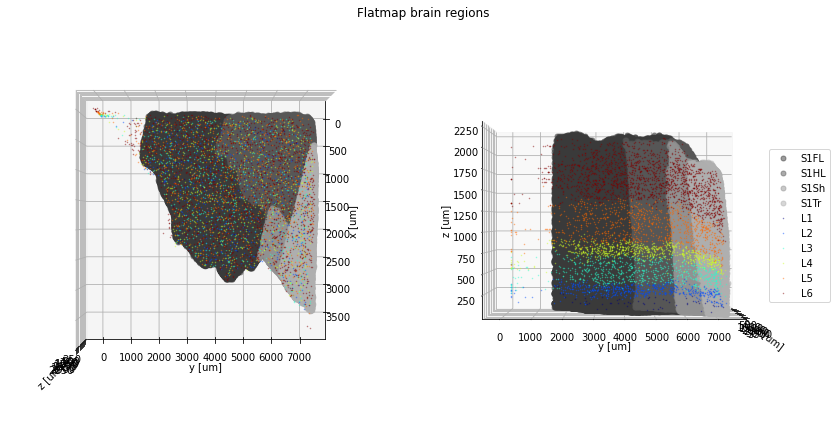

In [40]:
# Visualize flatmap regions + cell positions in flat space
views = [[90, 0], [0, 0]]
fig = plt.figure(figsize=(6 * len(views), 6))
plt.gcf().patch.set_facecolor('w')
for vidx, v in enumerate(views):
    ax = fig.add_subplot(1, len(views), vidx + 1, projection='3d')
    for ridx, rname in enumerate(reg_names):
        rids = np.array(reg_ids)[[rname in r for r in reg_acrs]]
        x, y = zip(*flatmap.raw[np.isin(brain_regions.raw, rids)])
        z = depths.raw[np.isin(brain_regions.raw, rids)]
        
        val = np.all(np.array([x, y, z]) != -1, 0)
        if np.any(val):
            plt.plot(np.array(x)[val] * pixel_scale[0], np.array(y)[val] * pixel_scale[1], np.array(z)[val], '.', color=rcolors[ridx, :], markersize=10, alpha=0.5, label=rname)
    
    for lidx in range(num_layers):
        pos = flat_pos_intpl.loc[np.intersect1d(c.cells.ids({'layer': lidx + 1}), cell_ids_sel)]
        plt.plot(pos['x'], pos['y'], pos['z'], '.', color=lcolors[lidx, :], markersize=1.0, alpha=0.5, label=f'L{lidx + 1}')
    
    ax.view_init(*v)
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')
    ax.set_zlabel('z [um]')
plt.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), ncol=1)
plt.suptitle('Flatmap brain regions')
plt.tight_layout()
plt.savefig(file_prefix + 'brain_regions_flat_space.png', dpi=300)
plt.show()

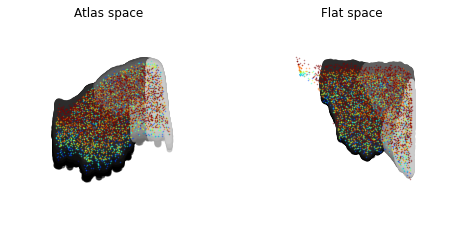

In [42]:
# Visualize atlas regions + cell positions in atlas vs. flat space
reg_names = list(filter(lambda x: x.split(';')[0] in ['S1FL', 'S1HL', 'S1Sh', 'S1Tr'], reg_acrs))
rcolors = plt.cm.gray(np.linspace(0.0, 0.8, len(reg_names)))
fig = plt.figure(figsize=(8, 4))
plt.gcf().patch.set_facecolor('w')

ax = fig.add_subplot(1, 2, 1, projection='3d')
for ridx, rname in enumerate(reg_names):
    rids = np.array(reg_ids)[[rname in r for r in reg_acrs]]
    x, y, z = zip(*brain_regions.indices_to_positions(np.array(np.where(np.isin(brain_regions.raw, rids))).T))
    plt.plot(x, y, z, '.', color=rcolors[ridx, :], markersize=10, alpha=0.5, label=rname)
for lidx in range(num_layers):
    pos = nrn_pos.loc[np.intersect1d(c.cells.ids({'layer': lidx + 1}), cell_ids_sel)]
    plt.plot(pos['x'], pos['y'], pos['z'], '.', color=lcolors[lidx, :], markersize=1.0, alpha=0.5, label=f'L{lidx + 1}')
ax.view_init(80, 0)
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
ax.set_zlabel('z [um]')
plt.axis('off')
plt.title('Atlas space')

ax = fig.add_subplot(1, 2, 2, projection='3d')
for ridx, rname in enumerate(reg_names):
    rids = np.array(reg_ids)[[rname in r for r in reg_acrs]]
    x, y = zip(*flatmap.raw[np.isin(brain_regions.raw, rids)])
    z = depths.raw[np.isin(brain_regions.raw, rids)]
    val = np.all(np.array([x, y, z]) != -1, 0)
    if np.any(val):
        plt.plot(np.array(x)[val] * pixel_scale[0], np.array(y)[val] * pixel_scale[1], np.array(z)[val], '.', color=rcolors[ridx, :], markersize=10, alpha=0.5, label=rname)
for lidx in range(num_layers):
    pos = flat_pos_intpl.loc[np.intersect1d(c.cells.ids({'layer': lidx + 1}), cell_ids_sel)]
    plt.plot(pos['x'], pos['y'], pos['z'], '.', color=lcolors[lidx, :], markersize=1.0, alpha=0.5, label=f'L{lidx + 1}')
ax.view_init(80, 0)
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
ax.set_zlabel('z [um]')
plt.axis('off')
plt.title('Flat space')

# plt.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.savefig(file_prefix + 'brain_regions_atlas_flat_space.png', dpi=300)
plt.show()

In [43]:
# Compare cell distances in atlas space vs. flat space
dist_mat = distance_matrix(nrn_pos.to_numpy(), nrn_pos.to_numpy())
dist_mat_flat = distance_matrix(flat_pos.to_numpy(), flat_pos.to_numpy())
dist_mat_flat_intpl = distance_matrix(flat_pos_intpl.to_numpy(), flat_pos_intpl.to_numpy())


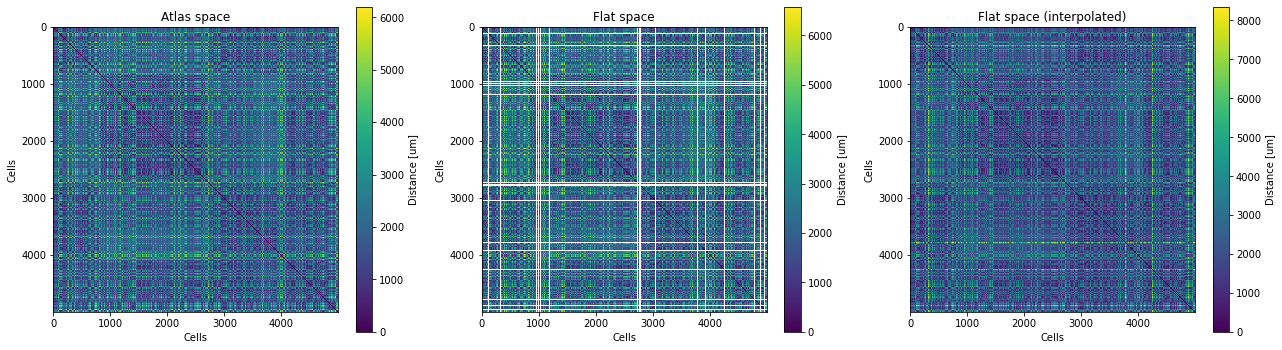

In [44]:
# Distance maps
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.imshow(dist_mat, interpolation='nearest')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.title('Atlas space')
plt.colorbar(label='Distance [um]')

plt.subplot(1, 3, 2)
plt.imshow(dist_mat_flat, interpolation='nearest')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.title('Flat space')
plt.colorbar(label='Distance [um]')

plt.subplot(1, 3, 3)
plt.imshow(dist_mat_flat_intpl, interpolation='nearest')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.title('Flat space (interpolated)')
plt.colorbar(label='Distance [um]')

plt.tight_layout()
plt.savefig(file_prefix + 'dist_maps.png', dpi=300)
plt.show()

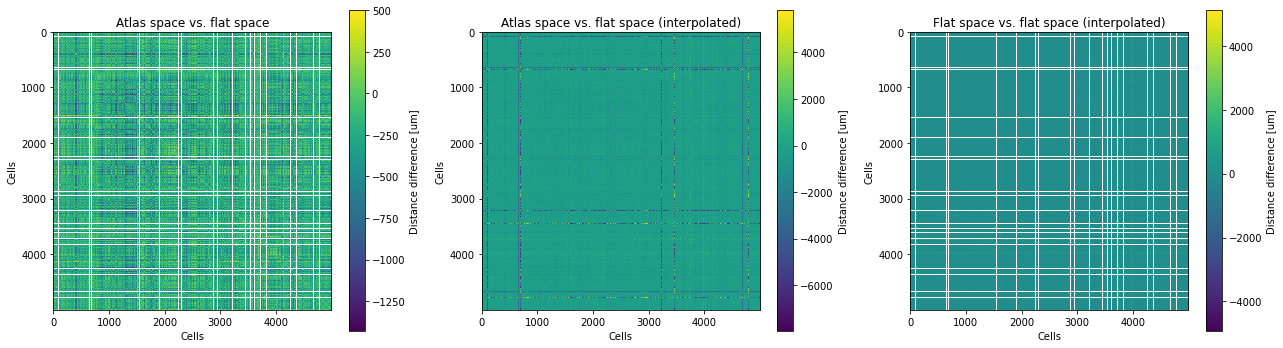

In [45]:
# Difference distance maps
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.imshow(dist_mat - dist_mat_flat, interpolation='nearest')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.title('Atlas space vs. flat space')
plt.colorbar(label='Distance difference [um]')

plt.subplot(1, 3, 2)
plt.imshow(dist_mat - dist_mat_flat_intpl, interpolation='nearest')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.title('Atlas space vs. flat space (interpolated)')
plt.colorbar(label='Distance difference [um]')

plt.subplot(1, 3, 3)
plt.imshow(dist_mat_flat - dist_mat_flat_intpl, interpolation='nearest')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.title('Flat space vs. flat space (interpolated)')
plt.colorbar(label='Distance difference [um]')

plt.tight_layout()
plt.savefig(file_prefix + 'dist_maps_diff.png', dpi=300)
plt.show()

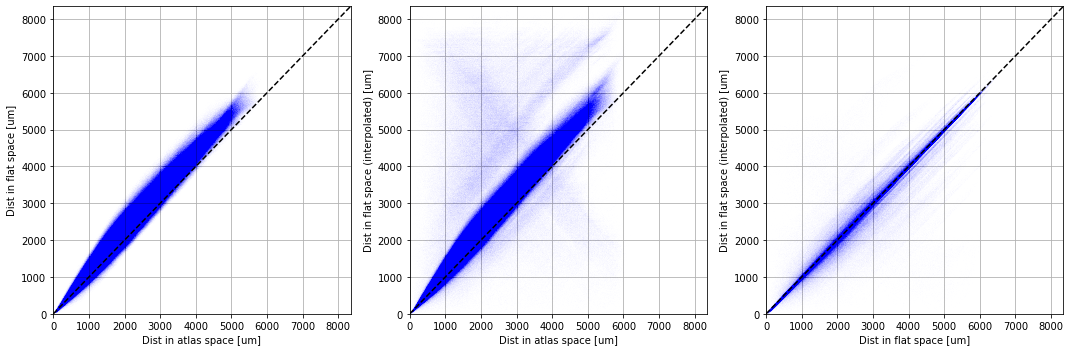

In [46]:
# Scatter plots
triu_idx = np.triu_indices_from(dist_mat, 1)

dist_val = dist_mat[triu_idx]
dist_val_flat = dist_mat_flat[triu_idx]
dist_val_flat_intpl = dist_mat_flat_intpl[triu_idx]

dist_max = max(max(dist_val), max(dist_val_flat), max(dist_val_flat_intpl))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(dist_val, dist_val_flat, 'b.', alpha=0.05, markersize=0.05)
plt.plot([0, dist_max], [0, dist_max], 'k--')
plt.xlim((0, dist_max))
plt.ylim((0, dist_max))
plt.grid(True)
plt.xlabel('Dist in atlas space [um]')
plt.ylabel('Dist in flat space [um]')

plt.subplot(1, 3, 2)
plt.plot(dist_val, dist_val_flat_intpl, 'b.', alpha=0.05, markersize=0.05)
plt.plot([0, dist_max], [0, dist_max], 'k--')
plt.xlim((0, dist_max))
plt.ylim((0, dist_max))
plt.grid(True)
plt.xlabel('Dist in atlas space [um]')
plt.ylabel('Dist in flat space (interpolated) [um]')

plt.subplot(1, 3, 3)
plt.plot(dist_val_flat, dist_val_flat_intpl, 'b.', alpha=0.05, markersize=0.05)
plt.plot([0, dist_max], [0, dist_max], 'k--')
plt.xlim((0, dist_max))
plt.ylim((0, dist_max))
plt.grid(True)
plt.xlabel('Dist in flat space [um]')
plt.ylabel('Dist in flat space (interpolated) [um]')

plt.tight_layout()
plt.savefig(file_prefix + 'dist_scatter_plots.png', dpi=300)
plt.show()

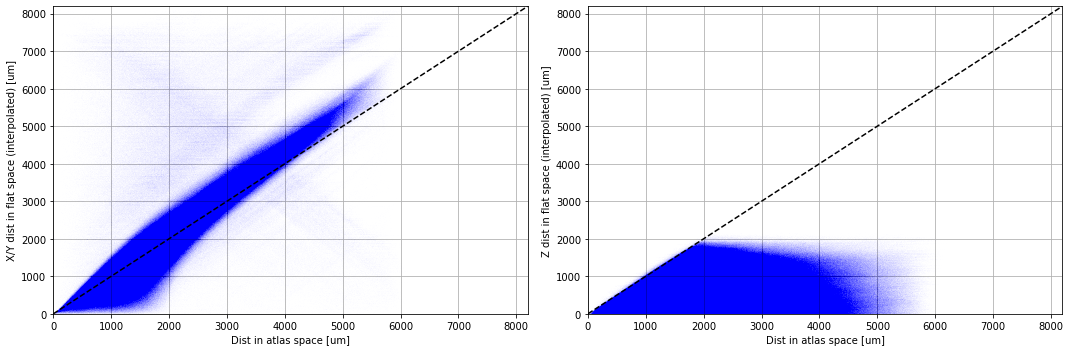

In [47]:
# Distance scatter plots in separately in x/y and z directions
dist_mat_flat_intpl_xy = distance_matrix(flat_pos_intpl[['x', 'y']].to_numpy(), flat_pos_intpl[['x', 'y']].to_numpy())
dist_mat_flat_intpl_z = distance_matrix(flat_pos_intpl[['z']].to_numpy(), flat_pos_intpl[['z']].to_numpy())

dist_val_flat_intpl_xy = dist_mat_flat_intpl_xy[triu_idx]
dist_val_flat_intpl_z = dist_mat_flat_intpl_z[triu_idx]

dist_max = max(max(dist_val_flat_intpl_xy), max(dist_val_flat_intpl_z))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(dist_val, dist_val_flat_intpl_xy, 'b.', alpha=0.05, markersize=0.05)
plt.plot([0, dist_max], [0, dist_max], 'k--')
plt.xlim((0, dist_max))
plt.ylim((0, dist_max))
plt.grid(True)
plt.xlabel('Dist in atlas space [um]')
plt.ylabel('X/Y dist in flat space (interpolated) [um]')

plt.subplot(1, 2, 2)
plt.plot(dist_val, dist_val_flat_intpl_z, 'b.', alpha=0.05, markersize=0.05)
plt.plot([0, dist_max], [0, dist_max], 'k--')
plt.xlim((0, dist_max))
plt.ylim((0, dist_max))
plt.grid(True)
plt.xlabel('Dist in atlas space [um]')
plt.ylabel('Z dist in flat space (interpolated) [um]')

plt.tight_layout()
plt.savefig(file_prefix + 'dist_scatter_plots_xy_z.png', dpi=300)
plt.show()

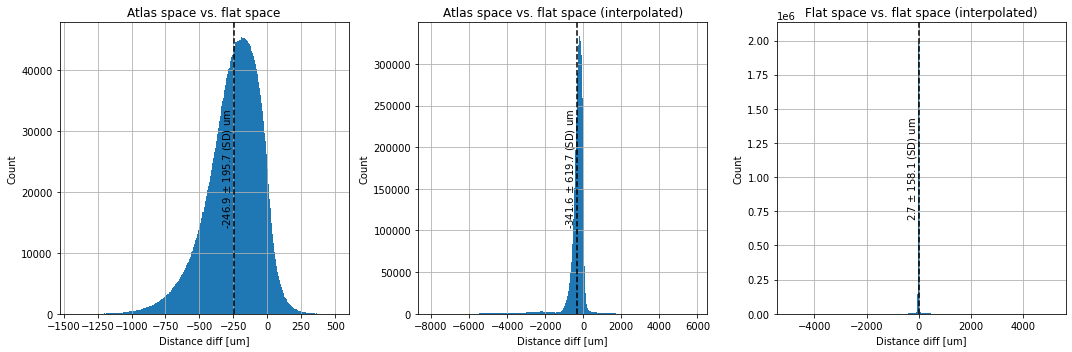

In [48]:
# Diff histograms
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dist_val - dist_val_flat, bins=1000)
plt.title('Atlas space vs. flat space')
plt.xlabel('Distance diff [um]')
plt.ylabel('Count')
plt.grid(True)
plt.ylim(plt.ylim())
plt.plot(np.nanmean(dist_val - dist_val_flat) * np.ones(2), plt.ylim(), 'k--')
plt.text(np.nanmean(dist_val - dist_val_flat), np.mean(plt.ylim()), f'{np.nanmean(dist_val - dist_val_flat):.1f} $\pm$ {np.nanstd(dist_val - dist_val_flat):.1f} (SD) um', color='k', ha='right', va='center', rotation=90)

plt.subplot(1, 3, 2)
plt.hist(dist_val - dist_val_flat_intpl, bins=1000)
plt.title('Atlas space vs. flat space (interpolated)')
plt.xlabel('Distance diff [um]')
plt.ylabel('Count')
plt.grid(True)
plt.ylim(plt.ylim())
plt.plot(np.nanmean(dist_val - dist_val_flat_intpl) * np.ones(2), plt.ylim(), 'k--')
plt.text(np.nanmean(dist_val - dist_val_flat_intpl), np.mean(plt.ylim()), f'{np.nanmean(dist_val - dist_val_flat_intpl):.1f} $\pm$ {np.nanstd(dist_val - dist_val_flat_intpl):.1f} (SD) um', color='k', ha='right', va='center', rotation=90)

plt.subplot(1, 3, 3)
plt.hist(dist_val_flat - dist_val_flat_intpl, bins=1000)
plt.title('Flat space vs. flat space (interpolated)')
plt.xlabel('Distance diff [um]')
plt.ylabel('Count')
plt.grid(True)
plt.ylim(plt.ylim())
plt.plot(np.nanmean(dist_val_flat - dist_val_flat_intpl) * np.ones(2), plt.ylim(), 'k--')
plt.text(np.nanmean(dist_val_flat - dist_val_flat_intpl), np.mean(plt.ylim()), f'{np.nanmean(dist_val_flat - dist_val_flat_intpl):.1f} $\pm$ {np.nanstd(dist_val_flat - dist_val_flat_intpl):.1f} (SD) um', color='k', ha='right', va='center', rotation=90)

plt.tight_layout()
plt.savefig(file_prefix + 'dist_diff_histograms.png', dpi=300)
plt.show()

100% |########################################################################|


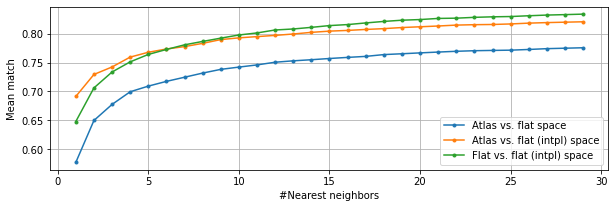

In [49]:
# Nearest neighbors
NN_mat = np.argsort(dist_mat, axis=1)
NN_mat_flat = np.argsort(dist_mat_flat, axis=1)
NN_mat_flat_intpl = np.argsort(dist_mat_flat_intpl, axis=1)

num_NN_list = list(range(1, 30, 1)) # + list(range(20, 101, 10))
NN_match = np.full((len(num_NN_list), 3), np.nan)

pbar = progressbar.ProgressBar()
for nidx in pbar(range(len(num_NN_list))):
    num_NN = num_NN_list[nidx]
    NN_match1 = [len(np.intersect1d(NN_mat[i, 1 : 1 + num_NN], NN_mat_flat[i, 1 : 1 + num_NN])) / num_NN for i in range(NN_mat.shape[0])]
    NN_match2 = [len(np.intersect1d(NN_mat[i, 1 : 1 + num_NN], NN_mat_flat_intpl[i, 1 : 1 + num_NN])) / num_NN for i in range(NN_mat.shape[0])]
    NN_match3 = [len(np.intersect1d(NN_mat_flat[i, 1 : 1 + num_NN], NN_mat_flat_intpl[i, 1 : 1 + num_NN])) / num_NN for i in range(NN_mat.shape[0])]
    NN_match[nidx, 0] = np.mean(NN_match1)
    NN_match[nidx, 1] = np.mean(NN_match2)
    NN_match[nidx, 2] = np.mean(NN_match3)

plt.figure(figsize=(10, 3))
plt.plot(num_NN_list, NN_match, '.-')
plt.grid(True)
plt.xlabel('#Nearest neighbors')
plt.ylabel('Mean match')
plt.legend(['Atlas vs. flat space', 'Atlas vs. flat (intpl) space', 'Flat vs. flat (intpl) space'])
plt.savefig(file_prefix + 'nearest_neighbor_match.png', dpi=300)
plt.show()


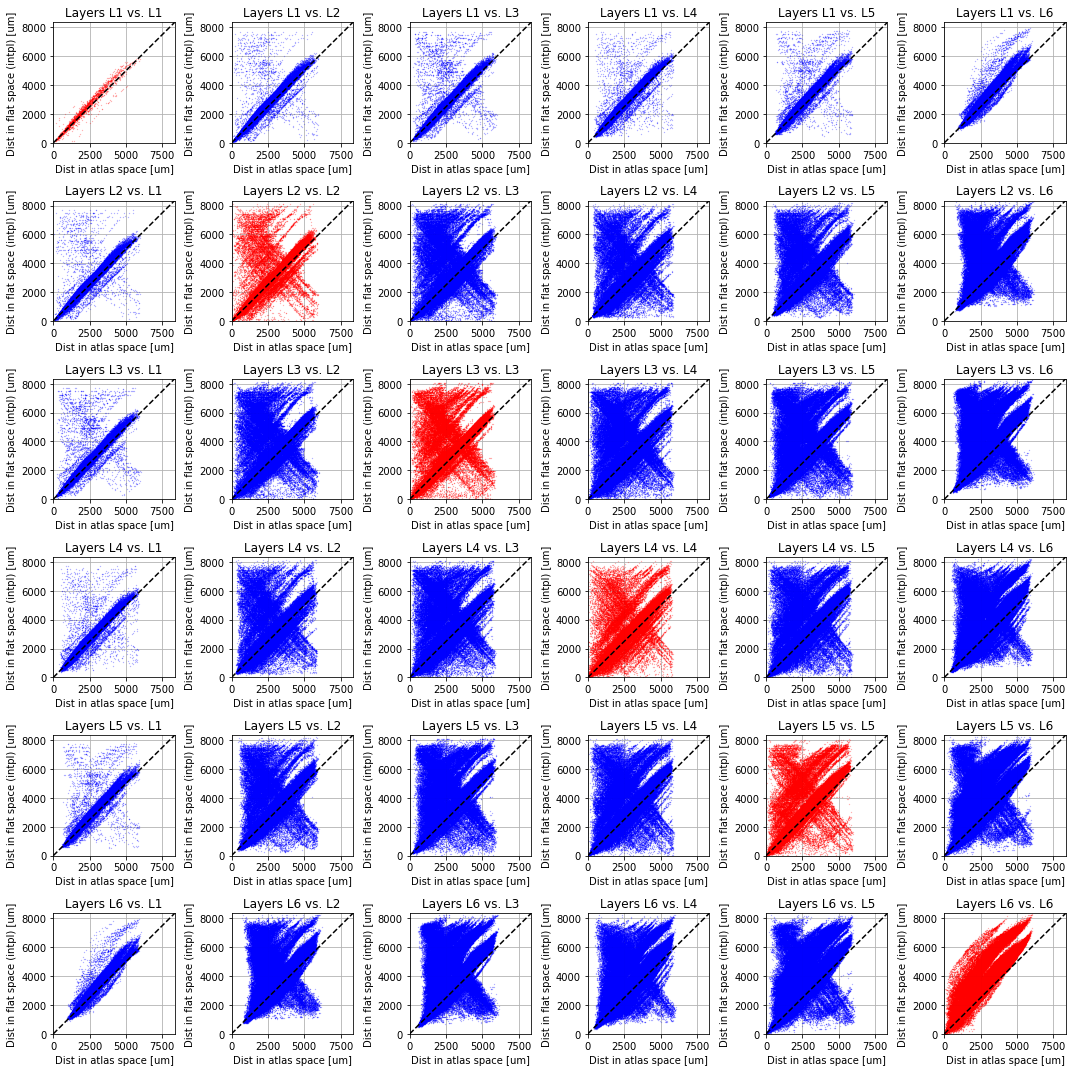

In [50]:
# Scatter plots within/across layers
cell_layers = c.cells.get(cell_ids_sel, properties=['layer'])
layers = np.unique(cell_layers)

dist_max = max(np.max(dist_mat), np.max(dist_mat_flat_intpl))
plt.figure(figsize=(15, 15))
for lidx1, lay1 in enumerate(layers):
    for lidx2, lay2 in enumerate(layers):

        dist_mat_layers = dist_mat[(cell_layers['layer']==lay1), :][:, (cell_layers['layer']==lay2)]
        dist_mat_layers_flat_intpl = dist_mat_flat_intpl[(cell_layers['layer']==lay1), :][:, (cell_layers['layer']==lay2)]

        if lay1 == lay2:
            triu_idx = np.triu_indices_from(dist_mat_layers, 1)
            dist_val_layers = dist_mat_layers[triu_idx]
            dist_val_layers_flat_intpl = dist_mat_layers_flat_intpl[triu_idx]
            col = 'r'
        else:
            dist_val_layers = dist_mat_layers.flatten()
            dist_val_layers_flat_intpl = dist_mat_layers_flat_intpl.flatten()
            col = 'b'
        
        plt.subplot(len(layers), len(layers), lidx1 * len(layers) + lidx2 + 1)
        plt.plot(dist_val_layers, dist_val_layers_flat_intpl, '.', color=col, alpha=0.5, markersize=0.5)
        plt.plot([0, dist_max], [0, dist_max], 'k--')
        plt.title(f'Layers L{lay1} vs. L{lay2}')
        plt.xlim((0, dist_max))
        plt.ylim((0, dist_max))
        plt.grid(True)
        plt.xlabel('Dist in atlas space [um]')
        plt.ylabel('Dist in flat space (intpl) [um]')
plt.tight_layout()
plt.savefig(file_prefix + 'dist_scatter_plots_layers.png', dpi=300)
plt.show()

DISTANCES in ATLAS SPACE vs. FLAT SPACE (INTERPOLATED):
2-1: 1052.8um vs. 1063.8um, diff= -11.0um
3-1: 5722.8um vs. 6141.4um, diff=-418.6um | 3-2: 5787.8um vs. 6145.6um, diff=-357.8um
4-1: 5821.1um vs. 6306.6um, diff=-485.5um | 4-2: 5823.9um vs. 6289.2um, diff=-465.4um | 4-3:  373.8um vs.  215.0um, diff= 158.7um
5-1: 1857.5um vs. 2132.5um, diff=-274.9um | 5-2: 2270.1um vs. 2670.1um, diff=-400.0um | 5-3: 5876.8um vs. 5671.3um, diff= 205.6um | 5-4: 5945.6um vs. 5866.4um, diff=  79.3um
6-1: 2086.0um vs. 2416.1um, diff=-330.1um | 6-2: 1677.8um vs. 2252.3um, diff=-574.5um | 6-3: 5721.5um vs. 5727.0um, diff=  -5.5um | 6-4: 5703.2um vs. 5892.2um, diff=-189.1um | 6-5: 1562.9um vs. 1599.3um, diff= -36.3um
7-1: 4745.6um vs. 8110.7um, diff=-3365.1um | 7-2: 4918.4um vs. 8124.7um, diff=-3206.3um | 7-3: 1984.5um vs. 1981.8um, diff=   2.8um | 7-4: 2040.3um vs. 1843.2um, diff= 197.1um | 7-5: 4353.7um vs. 7508.5um, diff=-3154.8um | 7-6: 4423.2um vs. 7585.4um, diff=-3162.1um
8-1: 6149.6um vs. 8346.5um, 

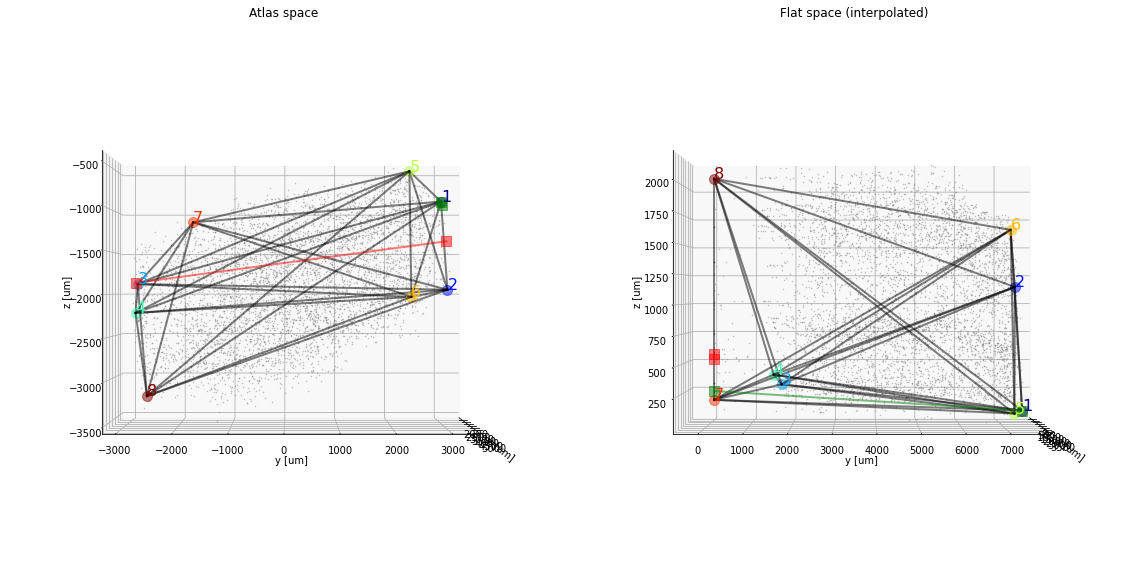

In [51]:
# Visualize selected neurons in 3D atlas space & 3D flat space
view_sel = (0, 0)

nrn_sel = np.array([nrn_pos.index[np.argmax( nrn_pos['x'] + nrn_pos['y'] + nrn_pos['z'])],
                    nrn_pos.index[np.argmax( nrn_pos['x'] + nrn_pos['y'] - nrn_pos['z'])],
                    nrn_pos.index[np.argmax( nrn_pos['x'] - nrn_pos['y'] + nrn_pos['z'])],
                    nrn_pos.index[np.argmax( nrn_pos['x'] - nrn_pos['y'] - nrn_pos['z'])],
                    nrn_pos.index[np.argmax(-nrn_pos['x'] + nrn_pos['y'] + nrn_pos['z'])],
                    nrn_pos.index[np.argmax(-nrn_pos['x'] + nrn_pos['y'] - nrn_pos['z'])],
                    nrn_pos.index[np.argmax(-nrn_pos['x'] - nrn_pos['y'] + nrn_pos['z'])],
                    nrn_pos.index[np.argmax(-nrn_pos['x'] - nrn_pos['y'] - nrn_pos['z'])]])

# nrn_sel = np.array([nrn_pos.index[np.argmax(nrn_pos['x'])], nrn_pos.index[np.argmax(nrn_pos['y'])], nrn_pos.index[np.argmax(nrn_pos['z'])], nrn_pos.index[np.argmin(nrn_pos['x'])], nrn_pos.index[np.argmin(nrn_pos['y'])], nrn_pos.index[np.argmin(nrn_pos['z'])]])

dist_mat_diff = dist_mat - dist_mat_flat_intpl
max_diff_sel = nrn_pos.index[np.where(dist_mat_diff == np.max(dist_mat_diff))[0]]
min_diff_sel = nrn_pos.index[np.where(dist_mat_diff == np.min(dist_mat_diff))[0]]

nrn_colors = plt.cm.jet(np.linspace(0, 1, len(nrn_sel)))
fig = plt.figure(figsize=(16, 8))
plt.gcf().patch.set_facecolor('w')

print('DISTANCES in ATLAS SPACE vs. FLAT SPACE (INTERPOLATED):')
for idx, (pos, lbl) in enumerate([[nrn_pos, 'Atlas space'], [flat_pos_intpl, 'Flat space (interpolated)']]):
    ax = fig.add_subplot(1, 2, idx + 1, projection='3d')
    plt.plot(pos['x'], pos['y'], pos['z'], '.', color='grey', markersize=1, alpha=0.5)
    for n1 in range(len(nrn_sel)):
        for n2 in range(len(nrn_sel)):
            if n1 < n2:
                continue
            elif n1 == n2:
                plt.plot(pos['x'][nrn_sel[n1]], pos['y'][nrn_sel[n1]], pos['z'][nrn_sel[n1]], 'o', color=nrn_colors[n1, :], markersize=10, alpha=0.5)
                ax.text(pos['x'][nrn_sel[n1]], pos['y'][nrn_sel[n1]], pos['z'][nrn_sel[n1]], str(n1 + 1), color=nrn_colors[n1, :], fontsize=16)
            else:
                plt.plot(pos['x'][nrn_sel[[n1, n2]]], pos['y'][nrn_sel[[n1, n2]]], pos['z'][nrn_sel[[n1, n2]]], color='k', linewidth=2, alpha=0.5)
                if idx == 0:
                    dist_atlas = dist_mat[nrn_pos.index == nrn_sel[n1], nrn_pos.index == nrn_sel[n2]][0]
                    dist_flat_intpl = dist_mat_flat_intpl[nrn_pos.index == nrn_sel[n1], nrn_pos.index == nrn_sel[n2]][0]
                    print(f'{n1 + 1}-{n2 + 1}: {dist_atlas:6.1f}um vs. {dist_flat_intpl:6.1f}um, diff={dist_atlas-dist_flat_intpl:6.1f}um', end='\n' if n1 - n2 == 1 else ' | ')
    
    plt.plot(pos['x'][max_diff_sel], pos['y'][max_diff_sel], pos['z'][max_diff_sel], 's-', color='r', markersize=10, linewidth=2, alpha=0.5)
    plt.plot(pos['x'][min_diff_sel], pos['y'][min_diff_sel], pos['z'][min_diff_sel], 's-', color='g', markersize=10, linewidth=2, alpha=0.5)
    ax.view_init(*view_sel)
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')
    ax.set_zlabel('z [um]')
    plt.title(lbl)

plt.tight_layout()
plt.savefig(file_prefix + 'nrn_sel_3D.png', dpi=300)
plt.show()